In [19]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import json
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns

# For reproducibility
np.random.seed(123)

In [6]:
with open('train.json', 'r') as myfile:
    data=myfile.read()

    # parse file
obj = json.loads(data)
df = pd.DataFrame(obj)

In [7]:
col = ['claim', 'label']
data = df[col]

In [8]:
data.head()

,claim,label
0,A line from George Orwell's novel 1984 predict...,0
1,Maine legislature candidate Leslie Gibson insu...,2
2,A 17-year-old girl named Alyssa Carson is bein...,1
3,In 1988 author Roald Dahl penned an open lette...,2
4,"When it comes to fighting terrorism, ""Another ...",2


In [9]:
data.shape

(15555, 2)

In [10]:
df=data

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.claim).toarray()
labels = df.label

X_train, X_test, y_train, y_test = train_test_split(df['claim'], df['label'], random_state = 123)


In [14]:
#Based on my previous baseline script, MultinomialNB has the best score,
#So I will test if resampling can improve the accuracy based on using MultinomialNB

#before resampling
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
print(classification_report(y_test,y_pred))  

              precision    recall  f1-score   support

           0       0.61      0.68      0.65      2431
           1       0.56      0.64      0.60      2153
           2       0.00      0.00      0.00       550

    accuracy                           0.59      5134
   macro avg       0.39      0.44      0.41      5134
weighted avg       0.53      0.59      0.56      5134



In [17]:
df['category_id'] = df['label'].values
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

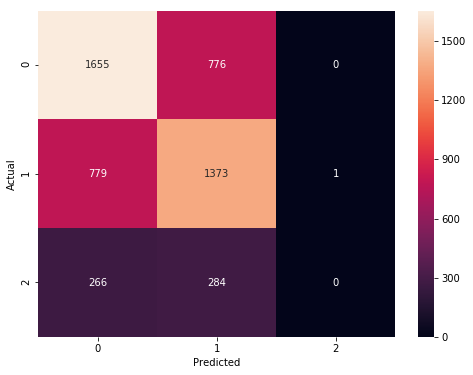

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
X_train.shape, y_train.shape

((10421, 7968), (10421,))

In [22]:
y_train.value_counts()

0    4977
1    4298
2    1146
Name: label, dtype: int64

In [23]:
#Resampling:
smote = SMOTE('minority')
# sm = SMOTE({0:4941, 1:4941, 2:4941}, random_state=123)
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(14252, 7968) (14252,)


In [24]:
model_rs = MultinomialNB()
model_rs.fit(X_sm,y_sm)
y_pred_rs = model_rs.predict(X_test)

In [25]:
print(classification_report(y_test,y_pred_rs))  

              precision    recall  f1-score   support

           0       0.64      0.59      0.61      2431
           1       0.58      0.48      0.53      2153
           2       0.17      0.34      0.23       550

    accuracy                           0.52      5134
   macro avg       0.46      0.47      0.45      5134
weighted avg       0.56      0.52      0.53      5134



In [43]:
df2=data

In [44]:
df2['category_id'] = df2['label'].values
category_id_df = df2[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

In [ ]:
y_test_labels = np.argmax(y_test, axis =1)

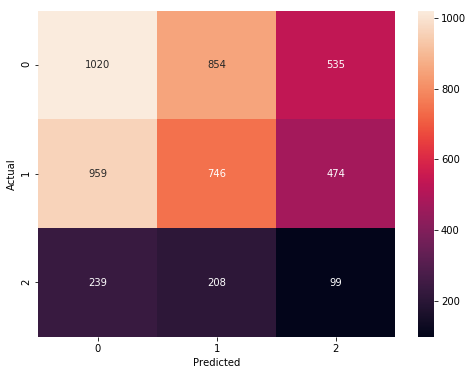

In [47]:
conf_mat = confusion_matrix(y_test_labels, y_pred_rs)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Try different model

In [27]:
# 3 news groups
num_labels = 3
vocab_size = 16000
batch_size = 100
num_epochs = 30

# lets take 67% data as training and remaining 33% for test.
train_size = int(len(data) * .67)

train_posts = data['claim'][:train_size]
train_tags = data['label'][:train_size]
# train_files_names = data['filename'][:train_size]

test_posts = data['claim'][train_size:]
test_tags = data['label'][train_size:]
# test_files_names = data['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [28]:
x_test.shape,y_test.shape

((5134, 16000), (5134, 3))

In [29]:
x_train.shape, y_train.shape


((10421, 16000), (10421, 3))

In [30]:
#let us build a basic model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               8192512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
__________

In [31]:
num_epochs =10
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Train on 8336 samples, validate on 2085 samples
Epoch 1/10
 - 15s - loss: 0.9404 - acc: 0.5537 - val_loss: 0.8849 - val_acc: 0.5995
Epoch 2/10
 - 13s - loss: 0.4428 - acc: 0.8303 - val_loss: 1.1997 - val_acc: 0.5530
Epoch 3/10
 - 13s - loss: 0.0970 - acc: 0.9725 - val_loss: 1.7789 - val_acc: 0.5530
Epoch 4/10
 - 13s - loss: 0.0215 - acc: 0.9964 - val_loss: 2.1061 - val_acc: 0.5492
Epoch 5/10
 - 14s - loss: 0.0091 - acc: 0.9992 - val_loss: 2.2725 - val_acc: 0.5458
Epoch 6/10
 - 16s - loss: 0.0064 - acc: 0.9993 - val_loss: 2.4035 - val_acc: 0.5448
Epoch 7/10
 - 14s - loss: 0.0062 - acc: 0.9993 - val_loss: 2.4294 - val_acc: 0.5463
Epoch 8/10
 - 14s - loss: 0.0054 - acc: 0.9994 - val_loss: 2.4986 - val_acc: 0.5458
Epoch 9/10
 - 14s - loss: 0.0037 - acc: 0.9994 - val_loss: 2.5730 - val_acc: 0.5516
Epoch 10/10
 - 14s - loss: 0.0029 - acc: 0.9996 - val_loss: 2.6622 - val_acc: 0.5492


In [32]:
score, acc = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=2)
print('Test accuracy:', acc)

Test accuracy: 0.5640825867118843


In [33]:
prediction = model.predict(x_test)

In [34]:
predictions = np.argmax(prediction, axis = 1)

In [35]:
predictions

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [36]:
y_test_labels = np.argmax(y_test, axis =1)

In [37]:
y_test_labels

array([1, 0, 0, ..., 0, 2, 1], dtype=int64)

In [38]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [39]:
print(classification_report(y_test_labels, predictions))  

              precision    recall  f1-score   support

           0       0.60      0.67      0.64      2409
           1       0.56      0.56      0.56      2179
           2       0.21      0.10      0.13       546

    accuracy                           0.56      5134
   macro avg       0.46      0.44      0.44      5134
weighted avg       0.54      0.56      0.55      5134



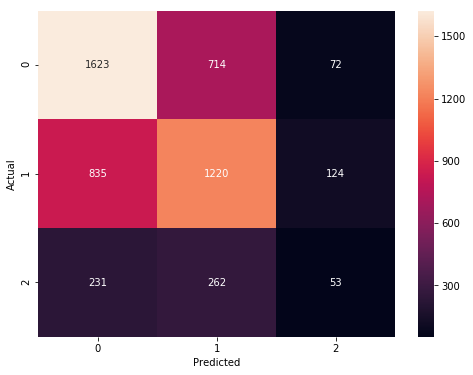

In [46]:
conf_mat = confusion_matrix(y_test_labels, predictions)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [48]:
#Use ratio='minority' to resample the minority class to remove class imbalance
smote = SMOTE('minority')
X_rs, y_rs = smote.fit_sample(x_train, y_train)
print(X_rs.shape, y_rs.shape)

(14270, 16000) (14270, 3)


In [49]:
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
num_epochs =10
batch_size = 128
history = model.fit(X_rs, y_rs,batch_size=batch_size,epochs=num_epochs,verbose=2,class_weight=class_weight,validation_split=0.2)

Train on 11416 samples, validate on 2854 samples
Epoch 1/10
 - 18s - loss: 0.3278 - acc: 0.9074 - val_loss: 0.0497 - val_acc: 0.9930
Epoch 2/10
 - 18s - loss: 0.0569 - acc: 0.9856 - val_loss: 0.0116 - val_acc: 0.9993
Epoch 3/10
 - 20s - loss: 0.0157 - acc: 0.9974 - val_loss: 0.0107 - val_acc: 0.9993
Epoch 4/10
 - 20s - loss: 0.0101 - acc: 0.9987 - val_loss: 0.0115 - val_acc: 0.9993
Epoch 5/10
 - 19s - loss: 0.0093 - acc: 0.9989 - val_loss: 0.0117 - val_acc: 0.9993
Epoch 6/10
 - 22s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0109 - val_acc: 0.9993
Epoch 7/10
 - 21s - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0108 - val_acc: 0.9993
Epoch 8/10
 - 19s - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0113 - val_acc: 0.9993
Epoch 9/10
 - 22s - loss: 0.0056 - acc: 0.9995 - val_loss: 0.0115 - val_acc: 0.9993
Epoch 10/10
 - 21s - loss: 0.0050 - acc: 0.9996 - val_loss: 0.0114 - val_acc: 0.9993


In [51]:
score, acc = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=2)
print('Test accuracy:', acc)

Test accuracy: 0.5597974289401664


In [53]:
prediction_rs = model.predict(x_test)

In [54]:
predictions_rs = np.argmax(prediction_rs, axis = 1)

In [55]:
print(classification_report(y_test_labels, predictions_rs))  

              precision    recall  f1-score   support

           0       0.60      0.67      0.64      2409
           1       0.55      0.55      0.55      2179
           2       0.19      0.10      0.13       546

    accuracy                           0.56      5134
   macro avg       0.45      0.44      0.44      5134
weighted avg       0.54      0.56      0.55      5134



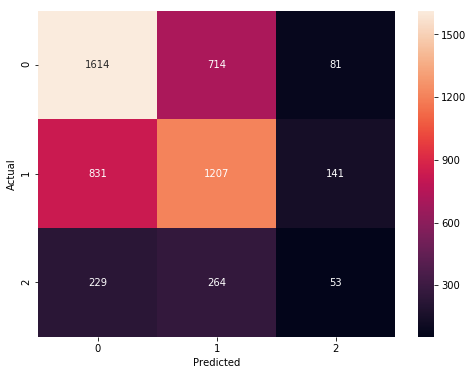

In [56]:
conf_mat = confusion_matrix(y_test_labels, predictions_rs)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()